In [ ]:
!unzip MNIST.zip_

In [3]:
import cv2

im = cv2.imread("./MNIST/0_0_10.jpg")
print(im.shape)

(28, 28, 3)


name:  7_5_53.jpg
<class 'numpy.ndarray'>
(28, 28)


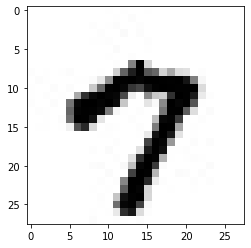

In [8]:
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
#import numpy as np

rootdir = './MNIST'
names = os.listdir(rootdir)

for name in names:
  print("name: ", name)
  path = os.path.join(rootdir, name)
  im = cv2.imread(path)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

  print(type(im))
  print(im.shape)

  # cv2.imshow('image', im) # BUG: crash the colab kernel
  cv2_imshow(im)
  plt.imshow(im.squeeze(), cmap='gray_r'); 
  
  break

In [ ]:
# 准备数据
import torch
from google.colab import drive
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('./mnist/MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('./mnist/MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)



In [ ]:
# 观察数据
import matplotlib.pyplot as plt

dataiter = iter(trainloader)
images, labels = next(dataiter)  # images [64, 1, 28, 28]，64 张，1 通道，28 宽，28 高 的图片  # labels [64] 64个标签
  # 28*28 = 784 个像素点，每张图片作为输入是[768] 的一维数组，每一批总共输入64 张，既是：[64, 784]
  # so, 输入层共784 个神经元结点，每个结点得到图片的其中一个像素作为输入
print(type(images))
print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');  # squeeze 将 [1, 28, 28] 降维成 [28, 28]


"""
输入： images[0].numpy().squeeze()
可以看到数值范围是：-1.0 ~ +1.0
"""
# import pdb; pdb.set_trace() # 调试， exit 退出


figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)  # 绘制  6 行，10 列 个对象
    plt.axis('off')            # 关闭坐标轴显示
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')



In [ ]:
# 训练
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

import os
from google.colab import drive


from torchvision import datasets, transforms
from torch import nn
from torch import optim

# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

criterion = nn.NLLLoss()


time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)  # 元素的总数不变，对维度重新进行解释，相当于 reshape  # 64 行，列数自适应(-1 的作用)  
          # 28*28 = 784 个像素点，每张图片作为输入是[784] 的一维数组，每一批总共输入64 张，既是：[64, 784]
    
        """
        输入： 
            images[0] 可以看到是张量 tensor，数值范围是：-1.0 ~ +1.0
            images[0].shape，可以看到维度是 784，是一维数组
            ((images[0]+1)/2)*255 ，数值范围规范为：0 ~ 255
        """
        #import pdb; pdb.set_trace() # 调试， exit 退出


        for i in range(len(images)):
          images[i] = ( (images[i]+1) / 2 ) # 原来的数值范围是 -1.0 ~ +1.0 ，规范为 0 ~ +1.0
        

        # Training pass
        optimizer.zero_grad()
        
        output = model(  images.cuda() if torch.cuda.is_available() else images.cpu() )
        loss = criterion(output, labels.cuda())
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


In [ ]:
# 验证模型精度
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    img = ( (img+1) / 2 ) # 原来的数值范围是 -1.0 ~ +1.0 ，规范为 0 ~ +1.0
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img.cuda())

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

In [ ]:
# 预测
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

images, labels = next(iter(valloader))

img = images[0].view(1, 784)
img = ( (img+1) / 2 ) # 原来的数值范围是 -1.0 ~ +1.0 ，规范为 0 ~ +1.0

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img.cuda())

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)